# Social Media Mining: Emotion
### Vincent Malic - Spring 2018

## Basic Emotions
* Define emotion for use with data mining algorithm
* Anger, fear, sadness, happiness, disgust, surprise

# Module 8.1 Emotion
* Use same set of 5000 tweets we collected for last week's lecture on sentiment. 
* 2500 tweets from Clinton twitter account, and 2500 tweets from Trump account.

In [1]:
import pandas as pd
df = pd.read_csv("sentimentanalysis.csv", index_col=0, encoding="latin1")

In [2]:
df.head()

,user,text,source,fav,rt
0,realDonaldTrump,"Remember, don't believe ""sources said"" by the ...",Twitter for Android,8572,3616
1,realDonaldTrump,Did Crooked Hillary help disgusting (check out...,Twitter for Android,12930,5628
2,realDonaldTrump,Using Alicia M in the debate as a paragon of v...,Twitter for Android,12738,5209
3,realDonaldTrump,"Wow, Crooked Hillary was duped and used by my ...",Twitter for Android,13210,5205
4,realDonaldTrump,Anytime you see a story about me or my campaig...,Twitter for Android,21316,9147


## Use NRC emotion lexicon as a pre-existing knowledge base
* Identify words in tweets with association for one of 8 Ekman emotions. 
* Download `NRC-emotion-lexicon` text file and read lexicon into our pandas as data frame. 

### Note: column values in ``.txt`` file separated by tabs.
* Pass argument called ``sep="\t"`` to indicate file is tab separated (not comma separated). 
* The first 46 rows of dataset are metadata pass argument, ``skiprows=45``, to skip rows 0-45.

In [3]:
nrc = pd.read_csv("NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt", sep="\t", names=["word", "emotion", "association"], skiprows=45)

## Look at NRC file format 

In [4]:
nrc.head(25)

,word,emotion,association
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
5,aback,negative,0
6,aback,positive,0
7,aback,sadness,0
8,aback,surprise,0
9,aback,trust,0


# NRC emotion lexicon format
* Each word in NRC (e.g., "aback", "abacus") has a row with *all 8* Ekman emotions *and* the values "positive" and "negative", which correspond to the sentiment polarity of the word. 
* Third column: value of ``1`` indicates a relationship between word and emotion/sentiment, (e.g., `abacus`, `trust`, `1`), value of 0 means *no* relationship. . 

## Filter data to only keep rows where third column == 1. 

In [5]:
nrc = nrc[nrc["association"] == 1]

## Remove pos./neg. sentiment markers 
* Remove all rows where second column == ``positive`` or == ``negative``, leaving only emotions.
* Select the rows that do not include rows with positive or negative in second column

In [6]:
nrc = nrc[nrc['emotion'].isin(['positive', 'negative']) == False]
nrc.head(25)

,word,emotion,association
19,abacus,trust,1
23,abandon,fear,1
27,abandon,sadness,1
30,abandoned,anger,1
33,abandoned,fear,1
37,abandoned,sadness,1
40,abandonment,anger,1
43,abandonment,fear,1
47,abandonment,sadness,1
48,abandonment,surprise,1


### Count how many words representing each emotion are in each tweet 
* Start with a single tweet.
* Unfortunately, we don't have a Python equivalent of the AFINN module 
* Perform the counting using the natural language tool kit (NLTK)

In [7]:
tweet = df.iloc[3442, :]
print(tweet.text)

RT @AndraDayMusic: I was honored to be a part of history at the DNC. Hillary Clinton is an inspiration for women everywhere.
https://t.co/E


# Tokenize tweet text with NLTK
* Use ``TweetTokenizer``to split tweet string into separate words,  
* Splits Twitter-specific words, like mentions and hashtags. 
* Use factory method ``TweetTokenizer`` to create an instance of tokenizer called, ``tt``.

In [8]:
from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()

tokenized = tt.tokenize(tweet.text)
print(tokenized)

['RT', '@AndraDayMusic', ':', 'I', 'was', 'honored', 'to', 'be', 'a', 'part', 'of', 'history', 'at', 'the', 'DNC', '.', 'Hillary', 'Clinton', 'is', 'an', 'inspiration', 'for', 'women', 'everywhere', '.', 'https://t.co/E']


## Put all words in `lowercase` in tokenized tweet.
* All words in the NRC are lower-case. 
* If ``Abhor``, with a capital ``A``, is in the text, it won't be found in the NRC: Python thinks ``Abhor`` and ``abhor`` are different words. 
* Use list comprehension to apply lower() function for each x in tokenized

In [9]:
tokenized = [x.lower() for x in tokenized]
print(tokenized)

['rt', '@andradaymusic', ':', 'i', 'was', 'honored', 'to', 'be', 'a', 'part', 'of', 'history', 'at', 'the', 'dnc', '.', 'hillary', 'clinton', 'is', 'an', 'inspiration', 'for', 'women', 'everywhere', '.', 'https://t.co/e']


## Go through all tokens 
* Count how many times emotion words appear. 
* Make an inventory of the emotions available to us.
* Save as a list, inventory of emotions

In [11]:
emotions = list(set(nrc['emotion']))
print(emotions)

['sadness', 'anticipation', 'anger', 'joy', 'disgust', 'surprise', 'fear', 'trust']


### Use ordering of  ``emotions`` list and create a **count vector** for each tweet. 
* Represent each tweet as vector of length 9, 
* Where the first element is the count of how many trust words occurred in it
* Second element is count of how many anticipation words occurred in it, etc. 

## Iterate through the tweets 
Create two dictionaries: 
* First, to indicate, **given an index number, what is its corresponding emotion** 
* Second, will indicate, **given an emotion, what is its corresponding index number**. 
* For i in range of lenth of emotions, set value of item to index, key emotion to index

In [12]:
index2emotion = {}
emotion2index = {}

for i in range(len(emotions)):
    index2emotion[i] = emotions[i]
    emotion2index[emotions[i]] = i

### With these two dictionaries, 
* Given an index, we can obtain an emotion, and 
* Given an emotion, we can obtain its index.

In [13]:
print(emotions)

['sadness', 'anticipation', 'anger', 'joy', 'disgust', 'surprise', 'fear', 'trust']


In [14]:
# What is the position index of the emotion "fear"?
emotion2index['fear']

6

In [15]:
# What emotion is associated with position index 6?
index2emotion[6]

'fear'

In [17]:
tokenized

['rt',
 '@andradaymusic',
 ':',
 'i',
 'was',
 'honored',
 'to',
 'be',
 'a',
 'part',
 'of',
 'history',
 'at',
 'the',
 'dnc',
 '.',
 'hillary',
 'clinton',
 'is',
 'an',
 'inspiration',
 'for',
 'women',
 'everywhere',
 '.',
 'https://t.co/e']

## Initialize empty count vector for single tweet we're working with. 
* We're going to initialize all values to 0.

In [16]:
cv = [0] * len(emotions)
print(cv)

[0, 0, 0, 0, 0, 0, 0, 0]


## Iterate through each word in tokenized tweet,
* Find what emotions are associated with it in the ``nrc`` data frame. 
* Subset NRC to contain ONLY the rows associated with *this* word
* Isolate the column emotion from sub; these are the emotions associated with this word
  * e represents one of the emotions associated with this token
  * What is the position index associated with this emotion?
  * Increment the variable cv at *this* position index by 1

In [18]:
for token in tokenized:                     # iterate through each word in list
    sub = nrc[nrc['word'] == token]         # subset nrc dataframe to select rows with word
    
    token_emotions = sub['emotion']         # get emotion associated with that word
    for e in token_emotions:                # for each emotion
        
        position_index = emotion2index[e]   # find its potition

        cv[position_index] += 1             # Update position index, increment by one

### Take a look at what happened to ``cv``. 
* Look up emotion associated with each emotion: anticipation, joy
* All values are 0 except for index 1 element and index 5. 
* Shows us how many times an emotional word occured in the tweet. 

In [19]:
cv

[0, 1, 0, 1, 0, 0, 0, 0]

In [22]:
index2emotion[1]

'anticipation'

In [23]:
index2emotion[3]

'joy'

# Package everything above into a function
* Repeat this process for all 5000 tweets. 

### Repeat this code, has to run for function to work
* We need two dictionaries, word associated with position index, index associated with word
* Name the function, takes a single argument, runs code, returns count vector `cv`

In [24]:
emotions = list(set(nrc['emotion']))
index2emotion = {}
emotion2index = {}
for i in range(len(emotions)):
    index2emotion[i] = emotions[i]
    emotion2index[emotions[i]] = i
    
# Here is the function
# Assumes that a TweetTokenizer called tt has been made
# and that the NRC lexicon has been imported as nrc
def makeEmoVector(tweettext):
    cv = [0] * len(emotions)
    tokenized = tt.tokenize(tweettext)
    tokenized = [x.lower() for x in tokenized]
    for token in tokenized:
        sub = nrc[nrc['word'] == token]
        token_emotions = sub['emotion']
        for e in token_emotions:
            position_index = emotion2index[e]
            cv[position_index] += 1
    return cv

### Take arbitrary tweet and represent it as emotion vector: 

In [26]:
tweettext = df.iloc[4231, :]['text']
makeEmoVector(tweettext)

[0, 0, 0, 1, 0, 0, 0, 2]

## Use this function, create an emotion vector for every tweet. 
* Make empty list called emotion vectors,
* Iterate through every tweet, and create emotion vector for every text
* Append that emotion vector to that empty list

In [27]:
emotion_vectors = []
for text in df['text']:
    emotion_vector = makeEmoVector(text)
    emotion_vectors.append(emotion_vector)

## Make emotion vectors in to a data frame
* Make sure that indices for ev are same for the indices for data

In [28]:
ev = pd.DataFrame(emotion_vectors, index=df.index, columns=emotions)
ev.head()

,sadness,anticipation,anger,joy,disgust,surprise,fear,trust
0,1,0,1,0,1,0,0,0
1,0,1,1,1,1,0,1,1
2,1,1,1,1,1,0,1,2
3,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0


## Merge this data frame with DF of original tweets. 

In [29]:
df = df.join(ev)
df.head()

,user,text,source,fav,rt,sadness,anticipation,anger,joy,disgust,surprise,fear,trust
0,realDonaldTrump,"Remember, don't believe ""sources said"" by the ...",Twitter for Android,8572,3616,1,0,1,0,1,0,0,0
1,realDonaldTrump,Did Crooked Hillary help disgusting (check out...,Twitter for Android,12930,5628,0,1,1,1,1,0,1,1
2,realDonaldTrump,Using Alicia M in the debate as a paragon of v...,Twitter for Android,12738,5209,1,1,1,1,1,0,1,2
3,realDonaldTrump,"Wow, Crooked Hillary was duped and used by my ...",Twitter for Android,13210,5205,1,1,1,1,1,1,1,1
4,realDonaldTrump,Anytime you see a story about me or my campaig...,Twitter for Android,21316,9147,0,0,0,0,0,0,0,0


### NOTE: *At the level of a tweet*
* This method will probably produce some visible inaccurate judgements. 
* By assigning emotions to tweets based on presence/absence of words, bound to be errors. 

### "noise" can be washed out by viewing things in aggregate.
* Use Pandas to see how emotions show up across *all* of tweets by each of candidates.
* Group all tweets together by each candidate that wrote the tweet with groupby() method.
* Groupby user, select emotions, and aggregate or sum the scores across all tweets

In [30]:
cand_group = df.groupby("user")

In [31]:
emo_counts = cand_group[emotions].agg("sum")
emo_counts

,sadness,anticipation,anger,joy,disgust,surprise,fear,trust
user,,,,,,,,
HillaryClinton,810,1236,852,966,352,1077,939,1865
realDonaldTrump,862,970,897,818,545,727,810,1467


## Perform an initial comparison of emotions
* Normalized these counts according to the total number of words used. 
* Possible that the two candidates used different amounts of words. 
* Get the total number of words tweeted by each candidate.

In [32]:
clintoncount = 0
clintonsub = df[df['user'] == "HillaryClinton"]
for text in clintonsub['text']:
    clintoncount += len(tt.tokenize(text))
print(clintoncount)

55583


In [33]:
trumpcount = 0
trumpsub = df[df['user'] == "realDonaldTrump"]
for text in trumpsub['text']:
    trumpcount += len(tt.tokenize(text))
print(trumpcount)

51413


## Use Pandas function ``divide``
* Divide each row in the emotion sums table by the total number of words.

In [34]:
emo_counts_normalized = emo_counts.divide([clintoncount, trumpcount], axis="rows")
emo_counts_normalized

,sadness,anticipation,anger,joy,disgust,surprise,fear,trust
user,,,,,,,,
HillaryClinton,0.014573,0.022237,0.015328,0.017379,0.006333,0.019376,0.016894,0.033553
realDonaldTrump,0.016766,0.018867,0.017447,0.015910,0.010600,0.014140,0.015755,0.028534


## Create visualization of table 
* If you imported matplotlib, you can use functions in Pandas for visualization of data frames 
* (http://pandas.pydata.org/pandas-docs/stable/visualization.html). 
* To display bar chart, first need to flip data frame for emotions in rows, candidates  columns, with Pandas function ``transpose()``. 

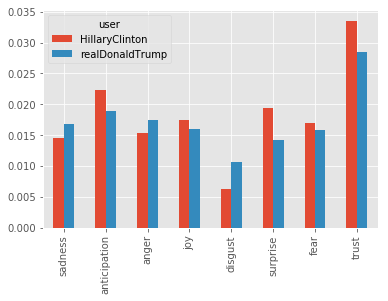

In [35]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

emo_counts_normalized.transpose().plot.bar()

### Plot summary
* Clinton seems to use words associated with trust, anticipation, and surprise more
* Trump has a lead in words expressing disgust
* Other values are a bit more even. 

### Explore differences in tweet source in Trump's tweets, 
* Doing something similar to the study we explored in the first lecture.

In [36]:
trump = df[df['user'] == "realDonaldTrump"]
trump = trump[trump['source'].isin(["Twitter for Android", "Twitter for iPhone"])]
source_group = trump.groupby("source")
emo_aggs = source_group[emotions].agg("sum")
emo_aggs

,sadness,anticipation,anger,joy,disgust,surprise,fear,trust
source,,,,,,,,
Twitter for Android,539,562,570,479,366,453,504,828
Twitter for iPhone,247,346,251,292,139,222,231,530


In [37]:
android_count = 0

for text in trump[trump['source'] == "Twitter for Android"]['text']:
    android_count += len(tt.tokenize(text))
    
iphone_count = 0

for text in trump[trump['source'] == "Twitter for iPhone"]['text']:
    iphone_count += len(tt.tokenize(text))
    
print("Android word_count: " + str(android_count))
print("iPhone word count: " + str(iphone_count))

Android word_count: 28878
iPhone word count: 18601


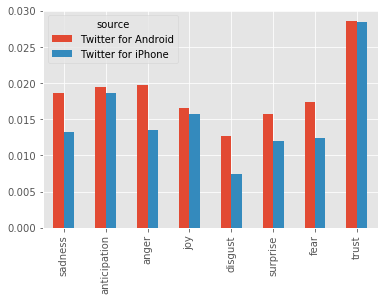

In [38]:
emo_aggs_normalized = emo_aggs.divide([android_count, iphone_count], axis="rows")
emo_aggs_normalized.transpose().plot.bar()

### Similar to David Robinson's analysis, we can see that
* Android user writes significantly more angry tweets than the iPhone user. 
* This also seems to be the case for anger, disgust, sadness, and fear, as well. 